In [22]:
# std lib
from getpass import getpass

# 3rd party
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from astropy.utils.data import download_file  #import file from URL
from scipy.stats import binned_statistic_2d
%matplotlib inline
from astropy.table import Table

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

print('Done importing')

Done importing


In [2]:
token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))

Enter user name: (+ENTER) yuxinhuang
Enter password: (+ENTER) ········


In [23]:
ac.whoAmI()

'yuxinhuang'

In [5]:
print(qc.schema('des_dr1'))


Schema: des_dr1

      Table Name   Description
      ----------   -----------
     des_allwise   ALLWISE 1-arcsec xmatch v. DES
       des_gaia2   Gaia DR2 1.5-arcsec xmatch v. DES
       des_galex   GALEX (AIS) 1-arcsec xmatch v. DES
        des_hsc2   HSC2 1-arcsec xmatch v. DES
      des_nscdr1   NSC DR1 1.5-arcsec xmatch v. DES
      des_simbad   SIMBAD 1-arcsec xmatch v. DES
            flux   Object flux table
       img2coadd   Images contributing to coadded tiles
             mag   Object magnitude table
            main   Main object table
       neighbors   Neighbors w/in 30-arcsec of each object
       tile_info   Survey tile information table
  x_gaia_dr2_2p5   Gaia DR1 2.5 arcsec xmatch v. DES



In [8]:
print(qc.schema('des_dr1.main'))


Schema: des_dr1
 Table: main

     Column Name   Description
     -----------   -----------
 coadd_object_id   Unique identifier for the coadded objects
         hpix_32   Healpix ID for nside=32, nested schema
         hpix_64   Healpix ID for nside=64, nested schema
       hpix_1024   Healpix ID for nside=1024, nested schema
       hpix_4096   Healpix ID for nside=4096, nested schema
      hpix_16384   Healpix ID for nside=16384, nested schema
              ra   Right ascension, with quantized precision for indexing (AL
                   PHAWIN_J2000 has full precision but not indexed)
             dec   Declination, with quantized precision for indexing (DELTAW
                   IN_J2000 has full precision but not indexed)
  alphawin_j2000   Right ascension for the object, J2000 in ICRS system (full
                   precision but not indexed)
  deltawin_j2000   Declination for the object, J2000 in ICRS (full precision 
                   but not indexed)
      galactic_l   Gala

In [3]:
RA180924 = (21 + 44/60 + 25/3600)/24*360
RA191001 = (21 + 33/60 + 24/3600)/24*360
RA181112 = (21 + 49/60 + 23/3600)/24*360

DEC180924 = - (40 + 54/60)
DEC191001 = - (54 + 44/60 + 54/3600)
DEC181112 = - (52 + 58/60 + 15/3600)

In [5]:
print(RA180924, DEC180924)
print(RA191001, DEC191001)
print(RA181112, DEC181112)

326.1041666666667 -40.9
323.35 -54.748333333333335
327.3458333333333 -52.97083333333334


In [56]:
# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT  mag_aper_8_r as rmag_aper, mag_auto_g as gmag, mag_auto_r as rmag, mag_auto_z as zmag, 
               mag_auto_i as imag, mag_auto_y as ymag, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(326.104)<1 and ra-(326.104)>-1 and dec-(-40.9)<1 and dec-(-40.9)>-1
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r<20.65)
        LIMIT 50000"""

# mag_auto_g,r,i,z,y = AB magnitudes in DECam g,r,i,z,y bands
# class_star_g,r,z   = star/extended source classifier (from 0 to 1)
# snr_g,r,z          = computed signal-to-noise ratios (S/N) in g,r,z bands
# ra,dec             = celestial coordinates

print(query)


        SELECT  mag_aper_8_r as rmag_aper, mag_auto_g as gmag, mag_auto_r as rmag, mag_auto_z as zmag, 
               mag_auto_i as imag, mag_auto_y as ymag, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(326.104)<1 and ra-(326.104)>-1 and dec-(-40.9)<1 and dec-(-40.9)>-1
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r<20.65)
        LIMIT 50000


In [59]:
%%time
# Execute the query synchronously, if short (e.g., LIMIT<=300,000)
# We then convert the returned result, a CSV-formatted string, to a Pandas data frame,
# making sure that any potential 'Infinity' values are converted to NaN.
res = qc.query(sql=query)
df = convert(res,'pandas')

ReadTimeout: HTTPSConnectionPool(host='datalab.noao.edu', port=443): Read timed out. (read timeout=300)

In [47]:
print(df[5:])
len(df)

   rmag_aper       gmag       rmag       zmag       imag       ymag  \
0  19.300238  20.576736  18.575518  20.513529  18.461241  23.653301   

   class_star_g  class_star_r  class_star_z    snr_g    snr_r    snr_z  \
0      0.002328      0.024005      0.019273  14.9555  82.0237  5.24629   

           ra        dec  
0  326.204088 -40.302922  


1

In [39]:
ra = df['ra'][:]
dec = df['dec'][:]
rmag = df['rmag'][:]
rmag_aper = df['rmag_aper'][:]
iin = np.where((rmag<19.8)*(ra-(326.104)<0.5)*(ra-(326.104)>-0.5)*(dec-(-40.9)<0.5)*(dec-(-40.9)>-0.5))
ra = np.array(ra)[iin]
dec = np.array(dec)[iin]
rmag = np.array(rmag)[iin]
rmag_aper = np.array(rmag_aper)[iin]

len(ra)

11208

19.79953956604 15.1862192153931


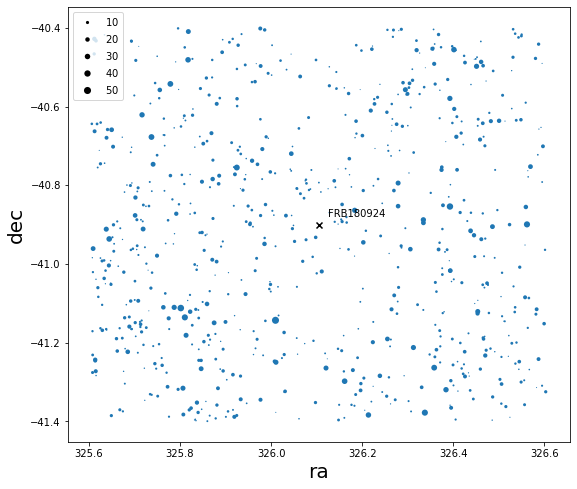

In [78]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag)-min(rmag)) * rmag + ((50-1)/(max(rmag)-min(rmag)) * max(rmag)+1), lw=0)
ax1.scatter(RA180924,DEC180924, marker='x', color='black')
ax1.annotate('FRB180924', xy = (RA180924,DEC180924),xytext = (RA180924+0.02,DEC180924+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag),min(rmag))

#plt.savefig('frb180924_auto_19.8_1df_753.png')

20.8483600616455 16.262769699096697


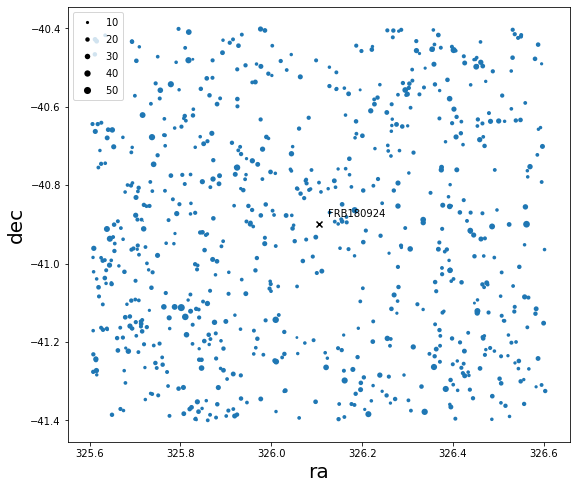

In [77]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag_aper)-min(rmag_aper)) * rmag_aper + ((50-1)/(max(rmag_aper)-min(rmag_aper)) * max(rmag_aper)+1), lw=0)
ax1.scatter(RA180924,DEC180924, marker='x', color='black')
ax1.annotate('FRB180924', xy = (RA180924,DEC180924),xytext = (RA180924+0.02,DEC180924+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag_aper),min(rmag_aper))

#plt.savefig('frb180924_aper_19.8_1df_753.png')

In [ ]:
FRB191001 323.35 -54.748333333333335

In [14]:
# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT mag_auto_g as gmag, mag_auto_r as rmag, mag_auto_z as zmag, 
               mag_auto_i as imag, mag_auto_y as ymag, mag_aper_8_r as rmag_aper, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(323.35)<1 and ra-(323.35)>-1 and dec-(-54.75)<1 and dec-(-54.75)>-1
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r<20.65)
        LIMIT 50000"""

# mag_auto_g,r,i,z,y = AB magnitudes in DECam g,r,i,z,y bands
# class_star_g,r,z   = star/extended source classifier (from 0 to 1)
# snr_g,r,z          = computed signal-to-noise ratios (S/N) in g,r,z bands
# ra,dec             = celestial coordinates

print(query)


        SELECT mag_auto_g as gmag, mag_auto_r as rmag, mag_auto_z as zmag, 
               mag_auto_i as imag, mag_auto_y as ymag, mag_aper_8_r as rmag_aper, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(323.35)<1 and ra-(323.35)>-1 and dec-(-54.75)<1 and dec-(-54.75)>-1
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r<20.65)
        LIMIT 50000


In [ ]:
%%time
# Execute the query synchronously, if short (e.g., LIMIT<=300,000)
# We then convert the returned result, a CSV-formatted string, to a Pandas data frame,
# making sure that any potential 'Infinity' values are converted to NaN.
res1 = qc.query(sql=query)
df1 = convert(res1,'pandas')

In [82]:
print(df1[:5])
len(df1)

        gmag       rmag       zmag       imag       ymag  rmag_aper  \
0  21.625433  19.872091  18.765137  19.136511  18.667292  19.912407   
1  21.023548  20.006342  19.354870  19.670464  19.460855  20.086422   
2  21.113667  20.292568  19.676630  19.977743  18.874521  20.360481   
3  21.757359  20.292662  19.488504  19.806112  19.414614  20.275425   
4  22.048756  20.544909  19.570704  19.936159  19.411814  20.545799   

   class_star_g  class_star_r  class_star_z    snr_g     snr_r     snr_z  \
0      0.015781      0.028615      0.028730  43.1147  128.9980  114.3140   
1      0.017894      0.028113      0.027225  58.8796   98.2534   56.7006   
2      0.020322      0.028203      0.413924  65.9156   99.5905   52.7426   
3      0.047447      0.029923      0.035696  41.5716  116.4850   74.8954   
4      0.018442      0.030813      0.029779  28.6104   84.3015   63.3308   

           ra        dec  
0  322.391439 -55.728105  
1  322.378895 -55.693493  
2  322.425423 -55.651655  
3  322.4

5994

In [105]:
ra = df1['ra'][:]
dec = df1['dec'][:]
rmag = df1['rmag'][:]
rmag_aper = df1['rmag_aper'][:]
iin = np.where((rmag<19.4)*(ra-(323.35)<0.5)*(ra-(323.35)>-0.5)*(dec-(-54.75)<0.5)*(dec-(-54.75)>-0.5))
ra = np.array(ra)[iin]
dec = np.array(dec)[iin]
rmag = np.array(rmag)[iin]
rmag_aper = np.array(rmag_aper)[iin]

len(ra)

464

19.3995742797852 14.933614730834998


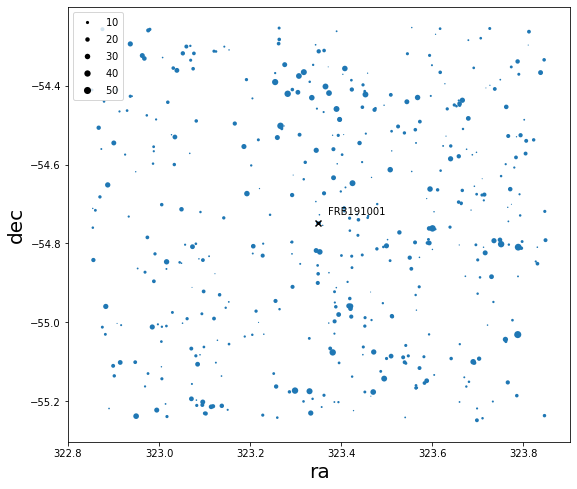

In [84]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag)-min(rmag)) * rmag + ((50-1)/(max(rmag)-min(rmag)) * max(rmag)+1), lw=0)
ax1.scatter(RA191001,DEC191001, marker='x', color='black')
ax1.annotate('FRB191001', xy = (RA191001,DEC191001),xytext = (RA191001+0.02,DEC191001+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag),min(rmag))

#plt.savefig('frb191001_auto_19.4_1df_464.png')

19.3995742797852 14.933614730834998


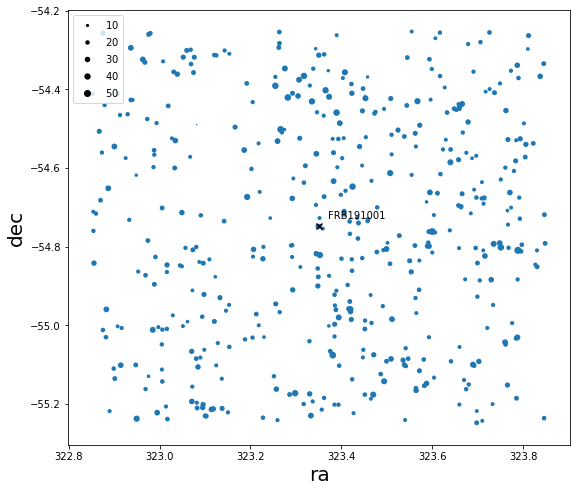

In [85]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag_aper)-min(rmag_aper)) * rmag_aper + ((50-1)/(max(rmag_aper)-min(rmag_aper)) * max(rmag_aper)+1), lw=0)
ax1.scatter(RA191001,DEC191001, marker='x', color='black')
ax1.annotate('FRB191001', xy = (RA191001,DEC191001),xytext = (RA191001+0.02,DEC191001+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag),min(rmag))

#plt.savefig('frb191001_aper_19.4_1df_464.png')

In [86]:
print(RA181112, DEC181112)

327.3458333333333 -52.97083333333334


In [87]:
# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT mag_auto_g as gmag, mag_auto_r as rmag, mag_auto_z as zmag, 
               mag_auto_i as imag, mag_auto_y as ymag, mag_aper_8_r as rmag_aper, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(327.346)<1 and ra-(327.346)>-1 and dec-(-52.971)<1 and dec-(-52.971)>-1
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_auto_r<20.6)
        LIMIT 50000"""

# mag_auto_g,r,i,z,y = AB magnitudes in DECam g,r,i,z,y bands
# class_star_g,r,z   = star/extended source classifier (from 0 to 1)
# snr_g,r,z          = computed signal-to-noise ratios (S/N) in g,r,z bands
# ra,dec             = celestial coordinates

print(query)


        SELECT mag_auto_g as gmag, mag_auto_r as rmag, mag_auto_z as zmag, 
               mag_auto_i as imag, mag_auto_y as ymag, mag_aper_8_r as rmag_aper, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(327.346)<1 and ra-(327.346)>-1 and dec-(-52.971)<1 and dec-(-52.971)>-1
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_auto_r<20.6)
        LIMIT 50000


In [88]:
%%time
# Execute the query synchronously, if short (e.g., LIMIT<=300,000)
# We then convert the returned result, a CSV-formatted string, to a Pandas data frame,
# making sure that any potential 'Infinity' values are converted to NaN.
res2 = qc.query(sql=query)
df2 = convert(res2,'pandas')

CPU times: user 61 ms, sys: 8 ms, total: 69 ms
Wall time: 2min 50s


In [106]:
ra = df2['ra'][:]
dec = df2['dec'][:]
rmag = df2['rmag'][:]
rmag_aper = df2['rmag_aper'][:]
iin = np.where((rmag<20.6)*(ra-(327.346)<0.5)*(ra-(327.346)>-0.5)*(dec-(-52.971)<0.5)*(dec-(-52.971)>-0.5))
ra = np.array(ra)[iin]
dec = np.array(dec)[iin]
rmag = np.array(rmag)[iin]
rmag_aper = np.array(rmag_aper)[iin]

len(ra)

1250

20.5991497039795 13.600948333740199


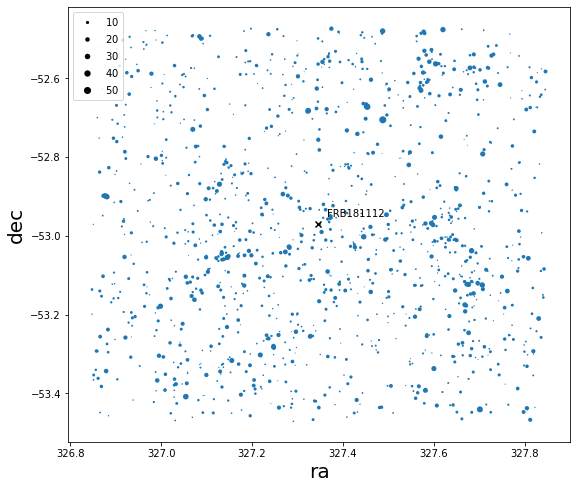

In [109]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag)-min(rmag)) * rmag + ((50-1)/(max(rmag)-min(rmag)) * max(rmag)+1), lw=0)
ax1.scatter(RA181112,DEC181112, marker='x', color='black')
ax1.annotate('FRB181112', xy = (RA181112,DEC181112),xytext = (RA181112+0.02,DEC181112+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag),min(rmag))

plt.savefig('frb181112_auto_20.6_1df_1250.png')

21.7195682525635 14.944062232971199


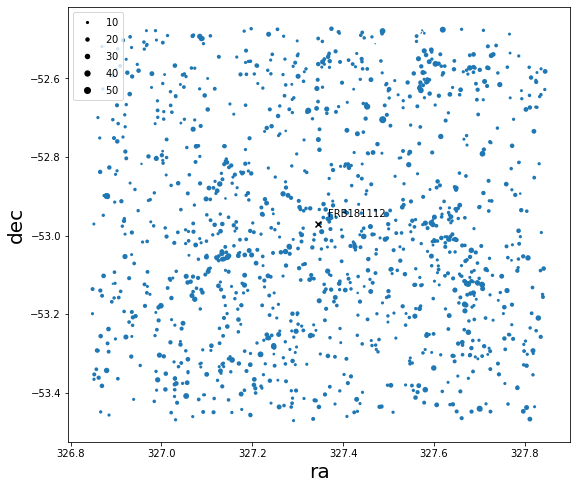

In [111]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag_aper)-min(rmag_aper)) * rmag_aper + ((50-1)/(max(rmag_aper)-min(rmag_aper)) * max(rmag_aper)+1), lw=0)
ax1.scatter(RA181112,DEC181112, marker='x', color='black')
ax1.annotate('FRB181112', xy = (RA181112,DEC181112),xytext = (RA181112+0.02,DEC181112+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag_aper),min(rmag_aper))

plt.savefig('frb181112_aper_20.6_1df_1250.png')